# LoC Data Package Tutorial: National Jukebox collection

This notebook will demonstrate basic usage of using Python for interacting with [data packages from the Library of Congress](https://data.labs.loc.gov/packages/) via the [National Jukebox data package](https://data.labs.loc.gov/jukebox/) which is derived from the Library's [National Jukebox Collection](https://www.loc.gov/collections/national-jukebox/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download an audio file and visualize it](#Download-an-audio-file-and-visualize-it)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First we will output a summary of the [National Jukebox data package](https://data.labs.loc.gov/jukebox/) contents

In [1]:
import io

import pandas as pd                     # for reading, manipulating, and displaying data
import requests

from helpers import get_file_stats

DATA_URL = 'https://data.labs.loc.gov/jukebox/' # Base URL of this data package

# Download the file manifest
file_manifest_url = f'{DATA_URL}manifest.json'
response = requests.get(file_manifest_url, timeout=60)
response_json = response.json()
files = [dict(zip(response_json["cols"], row)) for row in response_json["rows"]] # zip columns and rows

# Convert to Pandas DataFrame and show stats table
stats = get_file_stats(files)
pd.DataFrame(stats)

,FileType,Count,Size
0,.mp3,"5,882",17.0GB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular subject.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [2]:
metadata_url = f'{DATA_URL}metadata.json'
response = requests.get(metadata_url, timeout=60)
data = response.json()
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 5,882 entries.


Next let's convert to pandas DataFrame and print the available properties

In [3]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

Date, Description, Digitized, Id, IIIF_manifest, Preview_url, Audio_type, Contributors, Genre, Language, Media_size, Recording_catalog_number, Date_text, Recording_label, Location_text, Recording_matrix_number, Recording_take_id, Recording_take_number, Rights, Mime_type, Online_format, Original_format, Part_of, Repository, Number_of_files, Shelf_id, Subjects, Last_updated_in_api, Title, Type_of_resource, Url, Source_collection, Location


Next print the top 10 most frequent Subjects in this dataset

In [4]:
# Since "Subjects" are a list, we must "explode" it so there's just one subject per row
# We convert to DataFrame so it displays as a table
df['Subjects'].explode().value_counts().iloc[:10].to_frame()

,Subjects
Victor,5882
Vocal,3763
Popular music,2479
Instrumental,1870
Opera,933
Classical music,719
Ethnic characterizations,482
Musical theater,430
Humorous songs,423
Ethnic music,299


Now we filter the results to only those items with subject "Opera"

In [6]:
df_by_subject = df.explode('Subjects')
opera_set = df_by_subject[df_by_subject.Subjects == 'Opera']
print(f'Found {opera_set.shape[0]:,} items with subject "Opera"')

Found 933 items with subject "Opera"


## Download an audio file and visualize it

First we will merge the metadata with the file manifest to link the file URL to the respective item.

In [7]:
df_files = pd.DataFrame(files)
opera_set_with_audio = pd.merge(opera_set, df_files, left_on='Id', right_on='item_id', how='inner')
print(f'Found {opera_set_with_audio.shape[0]:,} opera items with audio files')

Found 933 opera items with audio files


Finally we will download the first audio file, then display its spectrogram

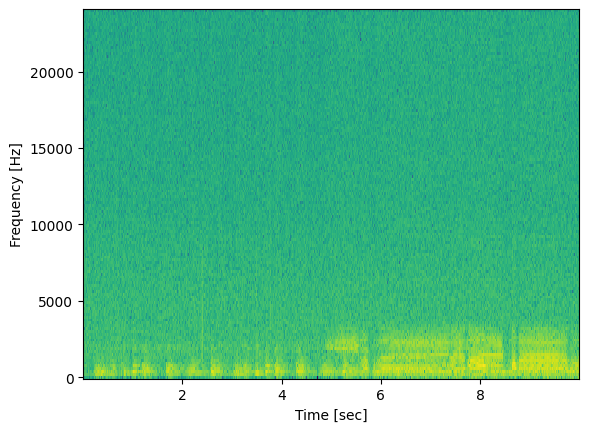

In [9]:
import io

import matplotlib.pyplot as plt         # for displaying data
import numpy as np
from pydub import AudioSegment          # for reading and manipulating audio files
from scipy import signal                # for visualizing audio

item = opera_set_with_audio.iloc[0]
file_url = f'https://{item["object_key"]}'

# Downoad the audio to memory
response = requests.get(file_url, timeout=60)
audio_filestream = io.BytesIO(response.content)

# Read as mp3
sample_rate = 48000
sample_width = 1
channels = 1
sound = AudioSegment.from_mp3(audio_filestream)
sound = sound.set_channels(channels)
sound = sound.set_sample_width(sample_width)
sound = sound.set_frame_rate(sample_rate)

# Get the first 10 seconds
ten_seconds = 10 * 1000
first_10_seconds = sound[:ten_seconds]

# Get audio samples and sample rate
samples = first_10_seconds.get_array_of_samples()
samples = np.array(samples)

# Visualize the results
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
plt.pcolormesh(times, frequencies, np.log(spectrogram))
# plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()